In [1]:
# REQUIREMENTS
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os, json
import datetime as dt
import pydot_ng as pydot

# solve the font issue in macOS
# ref: https://blog.csdn.net/fwj_ntu/article/details/105598145
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

In [2]:
# read files
dataset_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'datasets')
dataset_name = 'diakg'
dataset_path = os.path.join(dataset_path, dataset_name)
diakg = []

for file in os.listdir(dataset_path):
    if not file.endswith('.json'):
        # strip DS_Store
        continue
    file_path = os.path.join(dataset_path, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        diakg.append(json.load(f))

In [19]:
# TOOLS
def remove_none_label(l: dict) -> dict:
    """
    remove None label in labels
    :l: raw edge_label dictionary, key = node pair, value = edge label
    """
    
    mark = []

    # use iter() to reduce the memory cost, since the dict may be very large
    for key in iter(l):
        if l[key] == None:
            mark.append(key)

    for m in mark:
        l.pop(m)

    return l

def get_node_centric_graph(df, node_name):
    """
    :df: data frame
    :node_name: the center node name
    :output: retrieved new data frame with the centric node is node_name
    """

    sources, targets, relations = [], [], []

    for i in range(len(df['source'])):
        # the source is str
        if df.loc[i]['source'] == node_name:
            sources.append(node_name)
            targets.append(df.loc[i]['target'])
            relations.append(df.loc[i]['edge'])
        # the source the coordinator tuple
        elif isinstance(df.loc[i]['source'], tuple):
            if df.loc[i]['source'][0] == node_name:
                sources.append(df.loc[i]['source'])
                targets.append(df.loc[i]['target'])
                relations.append(df.loc[i]['edge'])
    
    new_df = pd.DataFrame({'source': sources, 'edge': relations, 'target': targets})

    return new_df

def draw_graph(df, root):
    """
    draw graph given a triple data frame
    """

    # create a directed-graph from a pandas dataframe
    G = nx.from_pandas_edgelist(df, source = 'source', target = 'target', edge_attr = 'edge', create_using = nx.DiGraph())

    plt.figure(figsize = (100, 100))
    # pos = nx.spring_layout(G)
    pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", root = root) 
    # pos = nx.kamada_kawai_layout(G, scale = 2)
    edge_labels = remove_none_label(nx.get_edge_attributes(G, 'edge'))
    # remove coordinator nodes 
    node_labels = {n: n for n in G if not isinstance(n, tuple)}
    # remove coordinator nodes 
    node_list = [i for i in list(G) if not isinstance(i, tuple)]

    # draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist = node_list)
    # draw all edges
    nx.draw_networkx_edges(G, pos)
    # draw labels for all desired nodes
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    # draw labels for all desired node-node edges
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # ref: https://blog.csdn.net/qq_38410428/article/details/89473470
    title = str(dt.datetime.now()) + '.png'
    plt.savefig(title, dpi = 'figure')

    plt.show()

    return

In [4]:
# construct the complete triples
sources, targets, relations = [], [], []
# entity_map: key = entity_id, value = entity_name
# relation_map: key = relation_id, value = relation_name/type
entity_map, relation_map = dict(), dict()
# some entities do not have a relationship with, ignore them for now
used_entity = set()

for doc in diakg:
    for paragraph in doc['paragraphs']:
        for sentence in paragraph['sentences']:
            for entity in sentence['entities']:
                if entity['entity_id'] not in entity_map.keys():
                    entity_map[entity['entity_id']] = entity['entity']
            for relation in sentence['relations']:
                source, target = entity_map[relation['tail_entity_id']], entity_map[relation['head_entity_id']]
                # some entity doesn't have a relation with others
                used_entity.add(source)
                used_entity.add(target)
                # build the sources-target-relation for true source and coordinator
                relation_type = relation['relation_type']
                mid_target = (source, relation_type)
                sources.append(source)
                targets.append(mid_target)
                relations.append(relation_type)
                # build the sources-target-relation for coordinator and true target
                sources.append(mid_target)
                targets.append(target)
                # set the relation as None
                relations.append(None)
                if relation['relation_id'] not in relation_map.keys():
                    relation_map[relation['relation_id']] = relation['relation_type']

df_complete = pd.DataFrame({'source': sources, 'edge': relations,'target': targets} )

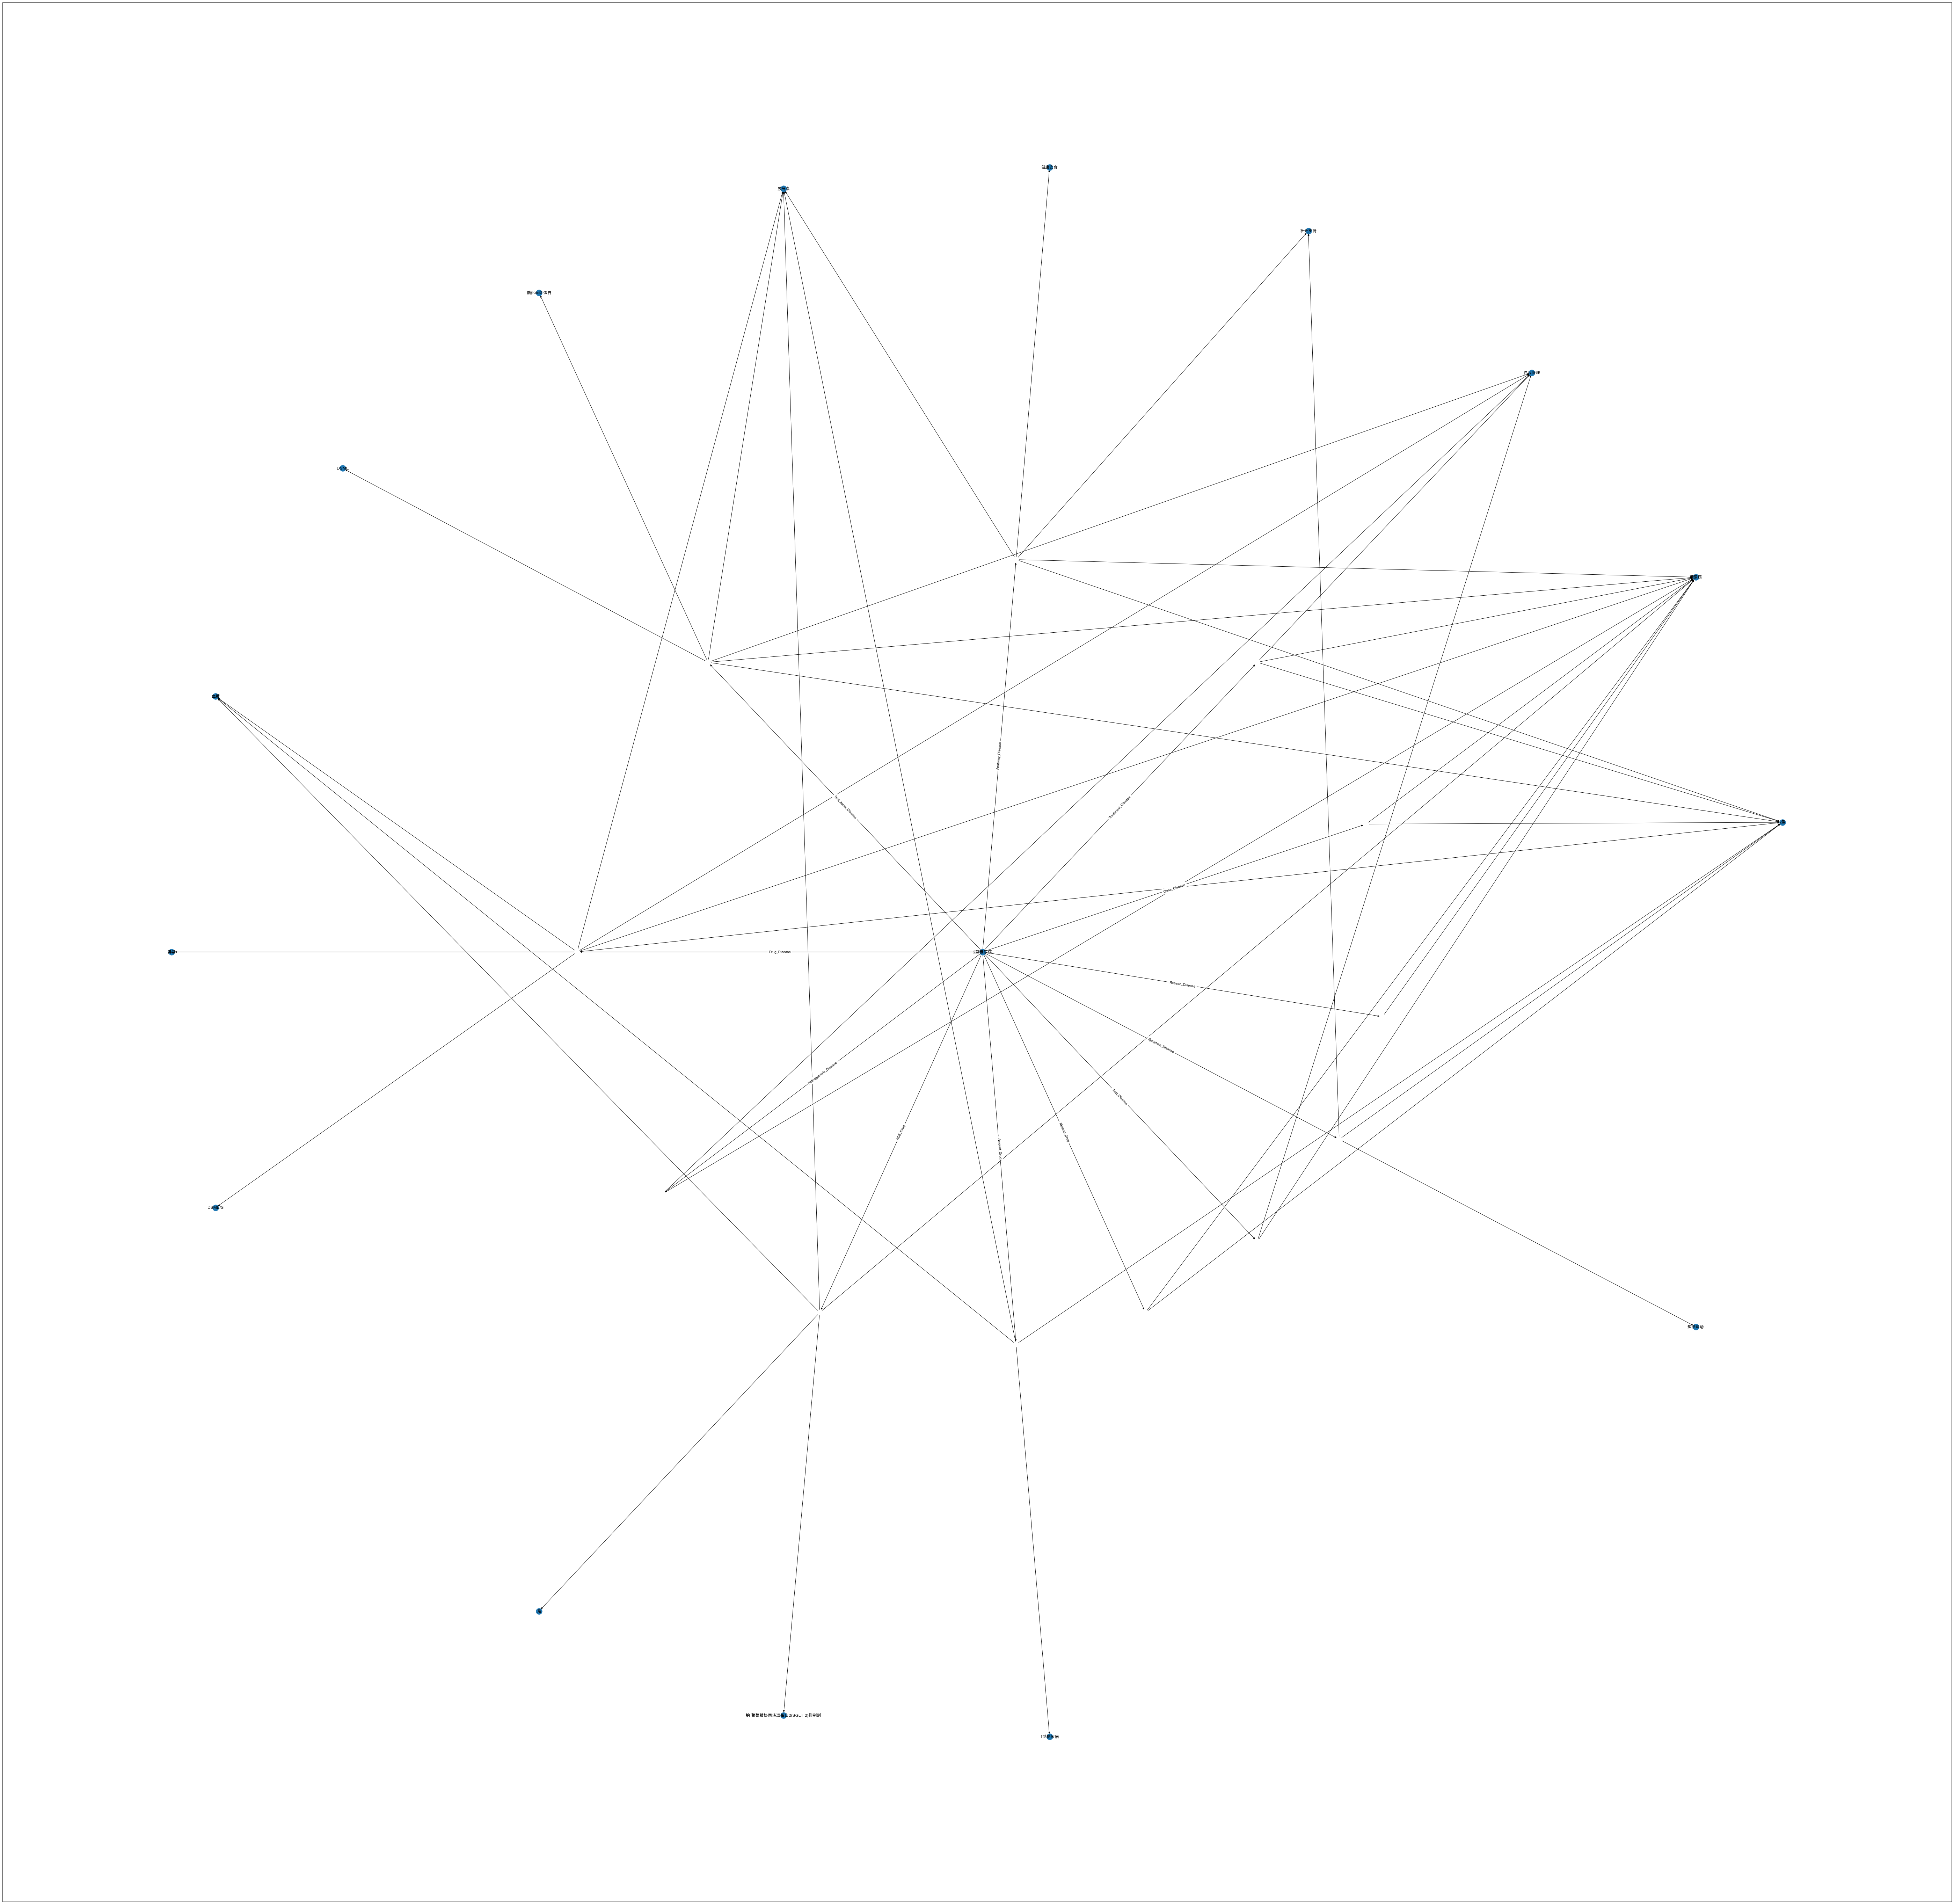

In [5]:
# example keywords: 血糖控制, 血糖监测, 2型糖尿病, 糖尿病, 
# 经过验证，图像应该是正确的
# root = '2型糖尿病'
# t = get_node_centric_graph(df_complete, root)
draw_graph(t, root)